In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.4.1


/home/junpenglao/anaconda3/envs/pymc-dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


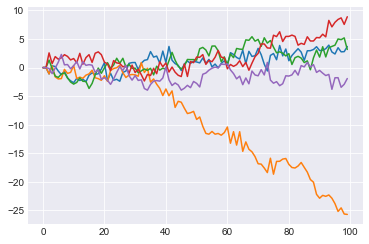

In [2]:
T, n = 100, 5
y = np.zeros((T, n))
beta0 = .45 + np.random.rand(2, n)*.1

for i in range(2, T):
    y[i] = beta0[0] * y[i-1] + beta0[1] * y[i-2] + np.random.randn(n)

plt.plot(y);

In [3]:
beta0

array([[0.46122736, 0.49614124, 0.533842  , 0.52197044, 0.52045441],
       [0.52104209, 0.53530284, 0.47106305, 0.54150172, 0.46406771]])

In [4]:
import theano.tensor as tt
from theano import scan
from pymc3.distributions.distribution import Continuous
from pymc3.distributions.continuous import get_tau_sd, Normal, Flat


class AR2d(Continuous):
    R"""
    Autoregressive process with p lags.
    .. math::
       x_t = \rho_0 + \rho_1 x_{t-1} + \ldots + \rho_p x_{t-p} + \epsilon_t,
       \epsilon_t \sim N(0,\sigma^2)
    The innovation can be parameterized either in terms of precision
    or standard deviation. The link between the two parametrizations is
    given by
    .. math::
       \tau = \dfrac{1}{\sigma^2}
    Parameters
    ----------
    rho : tensor
        Vector of autoregressive coefficients.
    sd : float
        Standard deviation of innovation (sd > 0). (only required if tau is not specified)
    tau : float
        Precision of innovation (tau > 0). (only required if sd is not specified)
    constant: bool (optional, default = False)
        Whether to include a constant.
    init : distribution
        distribution for initial values (Defaults to Flat())
    """

    def __init__(self, rho, sd=None, tau=None,
                 constant=False, init=Flat.dist(),
                 *args, **kwargs):

        super(AR2d, self).__init__(*args, **kwargs)
        tau, sd = get_tau_sd(tau=tau, sd=sd)
        self.sd = tt.as_tensor_variable(sd)
        self.tau = tt.as_tensor_variable(tau)

        self.mean = tt.as_tensor_variable(0.)

        rho = tt.as_tensor_variable(rho, ndim=2)
        if constant:
            self.p = rho.shape[0] - 1
        else:
            self.p = rho.shape[0]

        self.constant = constant
        self.rho = rho
        self.init = init

    def logp(self, value):
        if self.constant:
            results, _ = scan(lambda l_, obs, p, rho: rho[l_ - 1] * obs[p - l_:-l_],
                              outputs_info=None, sequences=[tt.arange(1, self.p + 1)],
                              non_sequences=[value, self.p, self.rho[1:]])
            x = tt.sum(results, axis=0)
            eps = value[self.p:] - self.rho[0] - x
        else:
            results, _ = scan(lambda l_, obs, p, rho: rho[l_ - 1] * obs[p - l_:-l_],
                              outputs_info=None, sequences=[tt.arange(1, self.p + 1)],
                              non_sequences=[value, self.p, self.rho])
            x = tt.sum(results, axis=0)
            eps = value[self.p:] - x

        innov_like = Normal.dist(mu=0.0, tau=self.tau).logp(eps)
        init_like = self.init.logp(value[:self.p])

        return tt.sum(innov_like) + tt.sum(init_like)

In [5]:
with pm.Model() as ar1:
    beta = pm.Uniform('beta', 0., 1., shape=(2, n))
    data = AR2d('y', beta, sd=1.0, observed=y)
    trace = pm.sample(1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:36<00:00, 166.09draws/s]


In [ ]:
pm.traceplot(trace, lines=dict(beta=beta0));

In [ ]:
pm.summary(trace)

In [ ]:
with pm.Model() as ar2:
    beta = pm.Uniform('beta', 0., 1., shape=(2, n))
    for i in range(n):
        pm.AR('y_%d'%i, beta[:, i], sd=1.0, observed=y[:, i])
    trace2 = pm.sample(1000, cores=4)

In [ ]:
pm.traceplot(trace2, lines=dict(beta=beta0));

In [ ]:
pm.summary(trace2)

In [ ]:
import theano.tensor as tt
from theano import scan
from pymc3.distributions.distribution import Continuous
from pymc3.distributions.continuous import get_tau_sd, Normal, Flat


class AR2d2(Continuous):
    R"""
    Autoregressive process with p lags.
    .. math::
       x_t = \rho_0 + \rho_1 x_{t-1} + \ldots + \rho_p x_{t-p} + \epsilon_t,
       \epsilon_t \sim N(0,\sigma^2)
    The innovation can be parameterized either in terms of precision
    or standard deviation. The link between the two parametrizations is
    given by
    .. math::
       \tau = \dfrac{1}{\sigma^2}
    Parameters
    ----------
    rho : tensor
        Vector of autoregressive coefficients.
    sd : float
        Standard deviation of innovation (sd > 0). (only required if tau is not specified)
    tau : float
        Precision of innovation (tau > 0). (only required if sd is not specified)
    constant: bool (optional, default = False)
        Whether to include a constant.
    init : distribution
        distribution for initial values (Defaults to Flat())
    """

    def __init__(self, rho, sd=None, tau=None,
                 constant=False, init=Flat.dist(),
                 *args, **kwargs):

        super(AR2d2, self).__init__(*args, **kwargs)
        tau, sd = get_tau_sd(tau=tau, sd=sd)
        self.sd = tt.as_tensor_variable(sd)
        self.tau = tt.as_tensor_variable(tau)

        self.mean = tt.as_tensor_variable(0.)
        
        if isinstance(rho, list):
            p = len(rho)
        else:
            try:
                p = rho.shape.tag.test_value[0]
            except AttributeError:
                p = rho.shape[0]

        if constant:
            self.p = p - 1
        else:
            self.p = p

        self.constant = constant
        self.rho = rho = tt.as_tensor_variable(rho)
        self.init = init

    def logp(self, value):
        if self.constant:
            x = tt.add(*[self.rho[i+1]*value[self.p-(i+1):-(i+1)] for i in range(self.p)])
            eps = value[self.p:] - self.rho[0] - x
        else:
            x = tt.add(*[self.rho[i]*value[self.p-(i+1):-(i+1)] for i in range(self.p)])
            eps = value[self.p:] - x

        innov_like = Normal.dist(mu=0.0, tau=self.tau).logp(eps)
        init_like = self.init.logp(value[:self.p])

        return tt.sum(innov_like) + tt.sum(init_like)

In [ ]:
with pm.Model() as ar1:
    beta = pm.Uniform('beta', 0., 1., shape=(2, n))
    data = AR2d2('y', beta, sd=1.0, observed=y)
    trace_ = pm.sample(1000, cores=4)

In [ ]:
pm.traceplot(trace_, lines=dict(beta=beta0));

In [ ]:
pm.summary(trace_)